In [26]:
import os
import re
import wave
import torch
import hashlib
import kagglehub
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

from torch import nn
from PIL import Image
from io import BytesIO
from scipy import signal
# from google.colab import drive
from torchsummary import summary
from IPython.display import Audio
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [27]:
BATCH_SIZE = 16
MAX_FREQ = 4000
CHUNK_SIZE = 16000
SAMPLE_RATE = 16000
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1

In [28]:
path = kagglehub.dataset_download("neehakurelli/google-speech-commands")

print("Path to dataset files:", path, "\n\nFiles:\n")

# !ls /root/.cache/kagglehub/datasets/neehakurelli/google-speech-commands/versions/1

Path to dataset files: /home/kuba/.cache/kagglehub/datasets/neehakurelli/google-speech-commands/versions/1 

Files:



In [29]:
def which_set(filename, validation_percentage, testing_percentage):
  base_name = os.path.basename(filename)
  hash_name = re.sub(r"_nohash_.*$", "", base_name)
  hash_name_hashed = hashlib.sha1(hash_name.encode()).hexdigest()
  percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                      (100.0 / MAX_NUM_WAVS_PER_CLASS))

  if percentage_hash < validation_percentage:
    result = "validation"

  elif percentage_hash < (testing_percentage + validation_percentage):
    result = "testing"

  else:
    result = "training"

  return result


def load_data(path, classes, validation_percentage=10, testing_percentage=10):
  data = []

  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    if not label in classes or not os.path.isdir(label_path):
      continue

    for file_name in os.listdir(label_path):
      if file_name.endswith(".wav"):
        file_path = os.path.join(label_path, file_name)
        category = which_set(file_name, validation_percentage, testing_percentage)

        data.append({
            "File_path": file_path,
            "Label": label,
            "Set": category
        })

  return pd.DataFrame(data)


classes = [x for x in os.listdir(path) if (x[0].islower() or x[0] == "_") and not ".txt" in x]
df = load_data(path, classes)
print(df.head())

train_data = df[df["Set"] == "training"][["File_path", "Label"]]
test_data = df[df["Set"] == "testing"][["File_path", "Label"]]
validation_data = df[df["Set"] == "validation"][["File_path", "Label"]]

print("\nTraining samples:", len(train_data))
print("Testing samples:", len(test_data))
print("Validation samples:", len(validation_data))

                                           File_path Label       Set
0  /home/kuba/.cache/kagglehub/datasets/neehakure...  nine  training
1  /home/kuba/.cache/kagglehub/datasets/neehakure...  nine  training
2  /home/kuba/.cache/kagglehub/datasets/neehakure...  nine   testing
3  /home/kuba/.cache/kagglehub/datasets/neehakure...  nine  training
4  /home/kuba/.cache/kagglehub/datasets/neehakure...  nine  training

Training samples: 51094
Testing samples: 6835
Validation samples: 6798


Label: off 




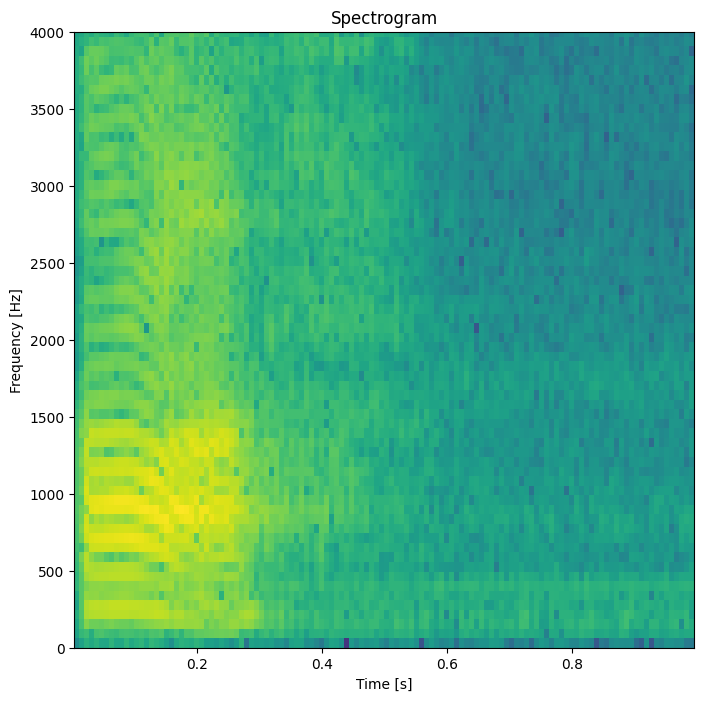

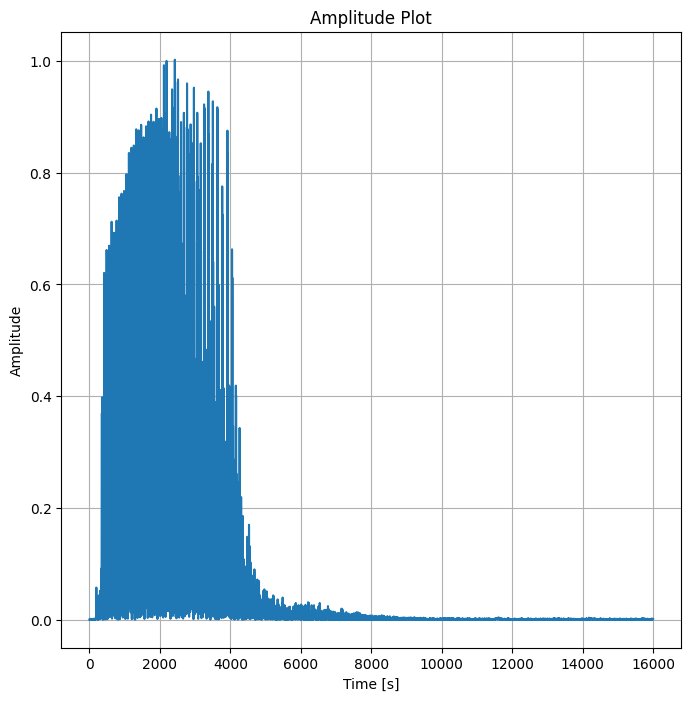

In [30]:
def plot_spectrogram(data):
  fig, ax = plt.subplots(figsize=(8, 8))

  ax.specgram(data, Fs=SAMPLE_RATE)
  ax.set_title("Spectrogram")
  ax.set_xlabel("Time [s]")
  ax.set_ylabel("Frequency [Hz]")
  ax.set_ylim(0, MAX_FREQ)

  plt.show()


def plot_amplitude(data):
  fig, ax = plt.subplots(figsize=(8, 8))

  ax.plot(np.abs(data))
  ax.set_title("Amplitude Plot")
  ax.set_xlabel("Time [s]")
  ax.set_ylabel("Amplitude")
  ax.grid()

  plt.show()


idx = 34000
file_path = train_data.iloc[idx]["File_path"]
label = train_data.iloc[idx]["Label"]
audio = None

with wave.open(file_path, "r") as wav_file:
  audio = wav_file.readframes(CHUNK_SIZE)
  audio = np.frombuffer(audio, dtype=np.int16)
  audio = audio / np.max(np.abs(audio))

print("Label:", label, "\n\n")
plot_spectrogram(audio)
print("\n")
plot_amplitude(audio)
print("\n")
Audio(file_path)

In [31]:
def file_to_spectrogram(file_path, save_path):
  with wave.open(file_path, "rb") as wav_file:
    audio = wav_file.readframes(CHUNK_SIZE)
    audio = np.frombuffer(audio, dtype=np.int16)
    audio = audio / np.max(np.abs(audio))

  fig, ax = plt.subplots(figsize=(1, 1), dpi=64)
  frequencies, times, Sxx = signal.spectrogram(audio, fs=SAMPLE_RATE)
  Sxx = np.clip(Sxx, 1e-10, None)
  ax.pcolormesh(times, frequencies, 10 * np.log10(Sxx, where=Sxx > 0), shading="auto")
  ax.axis("off")

  buf = BytesIO()
  plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
  buf.seek(0)

  img = Image.open(buf)
  img.save(save_path)

  plt.close(fig)
  buf.close()


def save_spectrograms(data, save_dir, lbl, other=False):
  save_path = None
  label = None

  for index, row in data.iterrows():
    if row["Label"] == lbl:
      if other:
        label = "other"

      else:
        label = row["Label"]

      file_path = row["File_path"]
      save_path = os.path.join(save_dir, f"{label}_{index}.png")
      file_to_spectrogram(file_path, save_path)


keywords = ["go", "stop", "bed"]

# drive.mount("/content/gdrive")
dir_path = "."
train_path = "train_data"
test_path = "test_data"
validation_path = "validation_data"

# os.makedirs(dir_path, exist_ok=True)
# os.makedirs(train_path, exist_ok=True)
# os.makedirs(test_path, exist_ok=True)
# os.makedirs(validation_path, exist_ok=True)

# for x in keywords:
#   idx = classes.index(x)
#   save_spectrograms(train_data, train_path, classes[idx])
#   save_spectrograms(test_data, test_path, classes[idx])
#   save_spectrograms(validation_data, validation_path, classes[idx])

In [32]:
def sample_data(df, labels, n_samples, random_state=0):
    grouped = df[df["Label"].isin(labels)]
    grouped_without_label = grouped.drop(columns=["Label"])

    sampled = grouped_without_label.groupby(grouped["Label"], group_keys=False).apply(
        lambda group: group.sample(n=min(len(group), n_samples), random_state=random_state)
    )

    sampled["Label"] = grouped["Label"].loc[sampled.index]

    return sampled.reset_index(drop=True)


# n_files = lambda p: len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))])
# other_classes = [cls for cls in classes if cls not in keywords]

# n_keywords_train = n_files(train_path) // len(keywords)
# n_keywords_test = n_files(test_path) // len(keywords)
# n_keywords_validation = n_files(validation_path) // len(keywords)

# n_other_train = n_keywords_train // len(other_classes)
# n_other_test = n_keywords_test // len(other_classes)
# n_other_validation = n_keywords_validation // len(other_classes)

# samples_other_train = sample_data(df[df["Set"] == "training"], other_classes, n_other_train)
# samples_other_train = sample_data(df[df["Set"] == "testing"], other_classes, n_other_test)
# samples_other_train = sample_data(df[df["Set"] == "validation"], other_classes, n_other_validation)

# for x in other_classes:
#   save_spectrograms(train_data, train_path, x)
#   save_spectrograms(test_data, test_path, x)
#   save_spectrograms(validation_data, validation_path, x)

In [33]:
class PNGDataset(Dataset):
  def __init__(self, root_dir, image_list=None, transform=None):
    self.root_dir = root_dir
    self.transform = transform

    if image_list:
      self.image_list = image_list

    else:
      self.image_list = os.listdir(self.root_dir)


  def __len__(self):
    return len(self.image_list)


  def __getitem__(self, idx):
    img_path = os.path.join(self.root_dir, self.image_list[idx])
    img = Image.open(img_path).convert("RGB")
    lbl = self.image_list[idx][:self.image_list[idx].find("_")]

    if self.transform:
        img = self.transform(img)

    return img, lbl

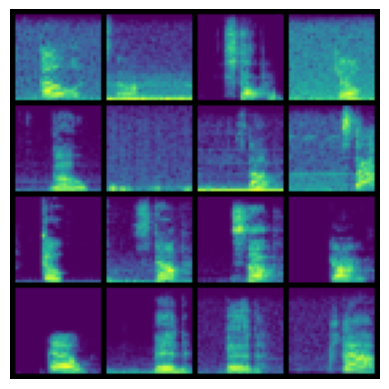

go stop stop go 
go stop stop stop 
go stop stop go 
go bed bed stop 


In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(PNGDataset(train_path, transform=transform),
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True)

test_loader = DataLoader(PNGDataset(test_path, transform=transform),
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         drop_last=True)

validation_loader = DataLoader(PNGDataset(validation_path, transform=transform),
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               drop_last=True)

n = 4
images, lbls = next(iter(train_loader))
imgs = []
image_grid = make_grid(images[:n ** 2], nrow=n, normalize=True)
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

for i in range(n):
  for j in range(n):
    print(lbls[n * i + j], end=" ")

  print()

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 128, kernel_size=(3, 3), padding=(1, 1))
    self.batch1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act1 = nn.GELU()
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

    self.conv2 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1))
    self.batch2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act2 = nn.GELU()
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

    self.conv3 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1))
    self.batch3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act3 = nn.GELU()
    self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

    self.conv4 = nn.Conv2d(512, 1024, kernel_size=(3, 3), padding=(1, 1))
    self.batch4 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act4 = nn.GELU()
    self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

    self.conv5 = nn.Conv2d(1024, 2048, kernel_size=(3, 3), padding=(1, 1))
    self.batch5 = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act5 = nn.GELU()
    self.pool5 = nn.MaxPool2d(kernel_size=(2, 2))

    self.flat = nn.Flatten()

    self.fc5 = nn.Linear(8192 , 4096)
    self.act5 = nn.GELU()

    self.fc6 = nn.Linear(4096, 2048)
    self.act6 = nn.GELU()

    self.fc7 = nn.Linear(2048, 4)
    self.act7 = nn.Softmax(dim=1)


  def forward(self, x):
    x = self.act1(self.conv1(x))
    x = self.pool1(x)

    x = self.act2(self.conv2(x))
    x = self.pool2(x)

    x = self.act3(self.conv3(x))
    x = self.pool3(x)

    x = self.act4(self.conv4(x))
    x = self.pool4(x)

    x = self.act5(self.conv5(x))
    x = self.pool5(x)

    x = self.flat(x)

    x = self.act5(self.fc5(x))
    x = self.act6(self.fc6(x))
    x = self.act7(self.fc7(x))

    return x

In [ ]:
# class ConvNet(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=(1, 1))
#     self.batch1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     self.act1 = nn.GELU()
#     self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

#     self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
#     self.batch2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     self.act2 = nn.GELU()
#     self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

#     self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1))
#     self.batch3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     self.act3 = nn.GELU()
#     self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

#     self.conv4 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1))
#     self.batch4 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     self.act4 = nn.GELU()
#     self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

#     self.flat = nn.Flatten()

#     self.fc5 = nn.Linear(2048, 1024)
#     self.act5 = nn.GELU()

#     self.fc6 = nn.Linear(1024, 512)
#     self.act6 = nn.GELU()

#     self.fc7 = nn.Linear(512, 4)
#     self.act7 = nn.Softmax(dim=1)


#   def forward(self, x):
#     x = self.act1(self.conv1(x))
#     x = self.pool1(x)

#     x = self.act2(self.conv2(x))
#     x = self.pool2(x)

#     x = self.act3(self.conv3(x))
#     x = self.pool3(x)

#     x = self.act4(self.conv4(x))
#     x = self.pool4(x)

#     x = self.flat(x)

#     x = self.act5(self.fc5(x))
#     x = self.act6(self.fc6(x))
#     x = self.act7(self.fc7(x))

#     return x

In [37]:
def weights_init(m):
  classname = m.__class__.__name__

  if isinstance(m, nn.Conv2d):
    nn.init.normal_(m.weight.data, 0.0, 0.02)

  elif isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ConvNet().to(device)
model.apply(weights_init)
v = (3, 64, 64)
summary(model, input_size=v)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              GELU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              GELU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              GELU-8            [-1, 256, 8, 8]               0
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Conv2d-10            [-1, 512, 4, 4]       1,180,160
             GELU-11            [-1, 512, 4, 4]               0
        MaxPool2d-12            [-1, 512, 2, 2]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                 [-

/home/kuba/.pyenv/versions/asar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Accuracy: 0.37%
Epoch 1: Precision: 0.1362, Recall: 0.3690, F1 Score: 0.1990
Epoch 2: Accuracy: 0.59%
Epoch 2: Precision: 0.6320, Recall: 0.5923, F1 Score: 0.5982
Epoch 3: Accuracy: 0.77%
Epoch 3: Precision: 0.7731, Recall: 0.7723, F1 Score: 0.7704
Epoch 4: Accuracy: 0.86%
Epoch 4: Precision: 0.8661, Recall: 0.8646, F1 Score: 0.8651
Epoch 5: Accuracy: 0.90%
Epoch 5: Precision: 0.9071, Recall: 0.9048, F1 Score: 0.9046
Epoch 6: Accuracy: 0.93%
Epoch 6: Precision: 0.9299, Recall: 0.9256, F1 Score: 0.9261
Epoch 7: Accuracy: 0.94%
Epoch 7: Precision: 0.9450, Recall: 0.9449, F1 Score: 0.9449
Epoch 8: Accuracy: 0.93%
Epoch 8: Precision: 0.9377, Recall: 0.9330, F1 Score: 0.9323
Epoch 9: Accuracy: 0.93%
Epoch 9: Precision: 0.9345, Recall: 0.9315, F1 Score: 0.9319
Epoch 10: Accuracy: 0.97%
Epoch 10: Precision: 0.9705, Recall: 0.9702, F1 Score: 0.9702
Epoch 11: Accuracy: 0.93%
Epoch 11: Precision: 0.9379, Recall: 0.9345, F1 Score: 0.9350
Epoch 12: Accuracy: 0.90%
Epoch 12: Precision: 0.9

/home/kuba/.pyenv/versions/asar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 36: Accuracy: 0.97%
Epoch 36: Precision: 0.9733, Recall: 0.9717, F1 Score: 0.9725
Epoch 37: Accuracy: 0.96%
Epoch 37: Precision: 0.9659, Recall: 0.9643, F1 Score: 0.9642
Epoch 38: Accuracy: 0.97%
Epoch 38: Precision: 0.9702, Recall: 0.9688, F1 Score: 0.9688


/home/kuba/.pyenv/versions/asar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 39: Accuracy: 0.96%
Epoch 39: Precision: 0.9658, Recall: 0.9613, F1 Score: 0.9629
Epoch 40: Accuracy: 0.97%
Epoch 40: Precision: 0.9679, Recall: 0.9673, F1 Score: 0.9671
Epoch 41: Accuracy: 0.97%
Epoch 41: Precision: 0.9701, Recall: 0.9688, F1 Score: 0.9689
Epoch 42: Accuracy: 0.97%
Epoch 42: Precision: 0.9721, Recall: 0.9717, F1 Score: 0.9718
Epoch 43: Accuracy: 0.96%
Epoch 43: Precision: 0.9565, Recall: 0.9554, F1 Score: 0.9556
Epoch 44: Accuracy: 0.97%
Epoch 44: Precision: 0.9662, Recall: 0.9658, F1 Score: 0.9658
Epoch 45: Accuracy: 0.96%
Epoch 45: Precision: 0.9594, Recall: 0.9568, F1 Score: 0.9571
Epoch 46: Accuracy: 0.98%
Epoch 46: Precision: 0.9763, Recall: 0.9762, F1 Score: 0.9761
Epoch 47: Accuracy: 0.97%
Epoch 47: Precision: 0.9733, Recall: 0.9717, F1 Score: 0.9718
Epoch 48: Accuracy: 0.97%
Epoch 48: Precision: 0.9719, Recall: 0.9702, F1 Score: 0.9704
Epoch 49: Accuracy: 0.96%
Epoch 49: Precision: 0.9643, Recall: 0.9613, F1 Score: 0.9615
Epoch 50: Accuracy: 0.96%
Epoch 

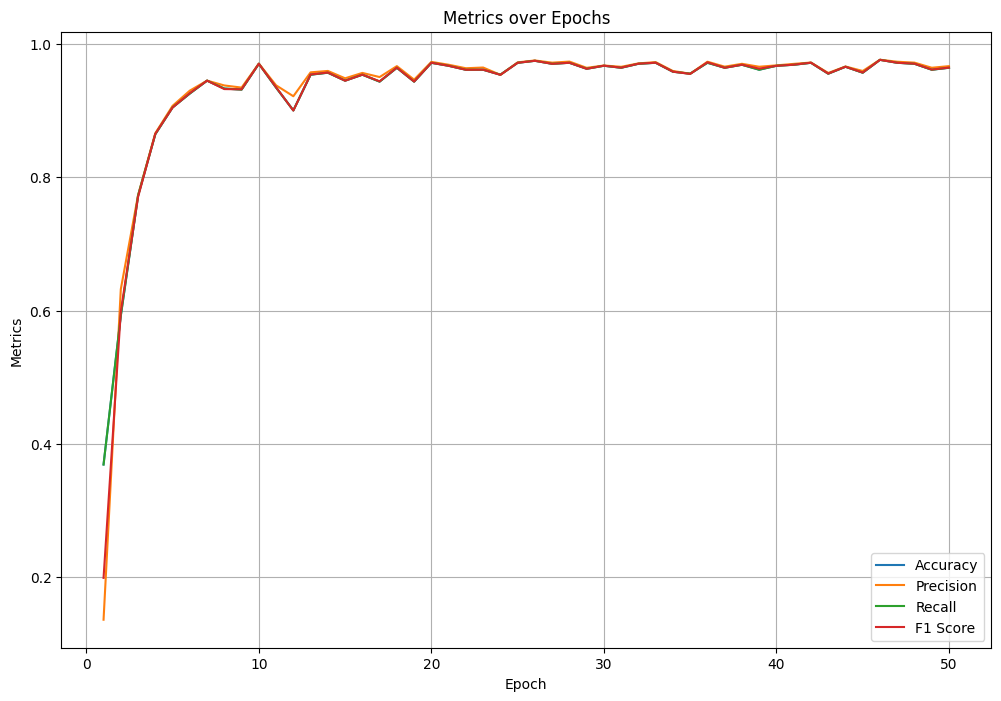

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

lbl_map = {"go": 0, "stop": 1, "bed": 2, "other": 3}
epochs = 50

accuracy_per_epoch = []
precision_per_epoch = []
recall_per_epoch = []
f1_per_epoch = []

for epoch in range(epochs):
  for i, (imgs, labels) in enumerate(train_loader):
    labels = torch.tensor(([lbl_map[lbl] if lbl in keywords else lbl_map["other"] for lbl in labels]))
    imgs, labels = imgs.to(device), labels.to(device)
    optimizer.zero_grad()
    output = model(imgs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

  correct = 0
  total = 0
  all_labels = []
  all_predictions = []

  with torch.no_grad():
    for imgs, labels in test_loader:
      labels = torch.tensor(([lbl_map[lbl] if lbl in keywords else lbl_map["other"] for lbl in labels]))
      imgs, labels = imgs.to(device), labels.to(device)
      outs = model(imgs)
      _, predicted = torch.max(outs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      all_labels.extend(labels.cpu().numpy())
      all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    # Store metrics
    accuracy_per_epoch.append(accuracy)
    precision_per_epoch.append(precision)
    recall_per_epoch.append(recall)
    f1_per_epoch.append(f1)

    print(f"Epoch {epoch + 1}: Accuracy: {accuracy:.2f}%")
    print(f"Epoch {epoch + 1}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Plot metrics
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.plot(range(1, epochs + 1), accuracy_per_epoch, label='Accuracy')
plt.plot(range(1, epochs + 1), precision_per_epoch, label='Precision')
plt.plot(range(1, epochs + 1), recall_per_epoch, label='Recall')
plt.plot(range(1, epochs + 1), f1_per_epoch, label='F1 Score')

plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("Metrics")

In [40]:
torch.save(model.state_dict(), dir_path + "/model")
weights = torch.load(dir_path + "/model")

for name, param in weights.items():
    print(name)

conv1.weight
conv1.bias
batch1.weight
batch1.bias
batch1.running_mean
batch1.running_var
batch1.num_batches_tracked
conv2.weight
conv2.bias
batch2.weight
batch2.bias
batch2.running_mean
batch2.running_var
batch2.num_batches_tracked
conv3.weight
conv3.bias
batch3.weight
batch3.bias
batch3.running_mean
batch3.running_var
batch3.num_batches_tracked
conv4.weight
conv4.bias
batch4.weight
batch4.bias
batch4.running_mean
batch4.running_var
batch4.num_batches_tracked
fc5.weight
fc5.bias
fc6.weight
fc6.bias
fc7.weight
fc7.bias


/tmp/ipykernel_143284/982806018.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(dir_path + "/model")
